## Package Description

`bmdrc` is a python library for calculating **B**ench**m**ark **D**ose **R**esponse **C**urves. This tutorial will take users through the library using a dichotomous (binary response) example. `bmdrc` is broken up into five modules 

1. *Input Data Module:* Import data into the python library.

2. *Pre-Processing Module:* Combine and remove endpoints as needed.

3. *Filtering Modules:* Apply recommended filters from the EPA and statistics experts.

4. *Model Fitting Modules:* Fit recommended models from the EPA and experts. The best fit model is autoselected for you.

5. *Output Modules:* Select tables to output as csvs. View plots in a HTML report.

First, install the package from pip using: 

`pip install bmdrc`

Or from github using: 

`pip install git+https://github.com/PNNL-CompBio/bmdrc`

## Datatype Description

**Dichotomous Data**

- *BinaryClass* The `BinaryClass` object contains specific pre-processing and filtering functions that pertain to plates and wells. Each value should be a 0, 1, or NA, and *bmdrc* will caculate the response column. The following columns are needed for data in long and wide format: chemical, plate, well, concentration. The following columns are only needed for data in wide format: endpoint, value. 

- *ProportionalClass* If your data does not contain plates and wells, the `ProportionalClass` object only requires a chemical, endpoint, concentration, and response (a proportion ranging from 0 to 1). Data must be in long format. 

- *LPRClass* In the `LPRClass`, larval photomotor response data can be converted to dichotomous as described in [Thomas et al 2019](https://www.sciencedirect.com/science/article/pii/S2468111318300732). Data must be in long format and contain the following columns: chemical, plate, well, concentration, time, and value. Users must specify the time between cycles, the cooldown time between cycles, and whether to start with a light or dark cycle. If this format does not fit your data nicely, please report it to the issues tab. 

**Continuous Data**

- *ContinuousClass* The `ContinuousClass` object requires only four columns: chemical, endpoint, concentration, and response (a continuous variable with any range). All selected models support negative numbers and zeroes. NA values are automatically filtered out. 

In [1]:
# Load local libraries
import bmdrc 
import pandas as pd

## Module 1: Input Data

The first step to using the bmdrc python library is to properly format the data. For dichotmous data, use the `BinaryClass` object which can be imported using `from bmdrc.BinaryClass import BinaryClass`. Next, read the data as a pandas dataframe. Note that the data can be in either wide or long format, but if provided in wide format, there are some assumptions made about data structure. 

### Long Format

Here is an example of the data in long format, with a column for the chemical (chemical.id), concentration (concentration), plate ID (plate.id), well name (well), endpoint measured (endpoint), and value (0 for No and 1 for Yes)

In [2]:
pd.read_csv("../data/Binary_Simplified_Long.csv").head().drop("Notes", axis = 1)

,chemical.id,concentration,plate.id,well,endpoint,value
0,1,0.0,A,1,DP24,1
1,1,0.0,A,2,DP24,1
2,1,0.0,A,3,DP24,1
3,1,0.0,A,4,DP24,0
4,1,0.0,A,5,DP24,0


Here's how you create a binary class object with this data and information. 

In [3]:
from bmdrc.BinaryClass import BinaryClass

Long = BinaryClass(
    df = pd.read_csv("../data/Binary_Simplified_Long.csv").drop("Notes", axis = 1), # Input is a pandas DataFrame
    chemical = "chemical.id", # The name of the chemical column 
    plate = "plate.id", # The name of the plate ID column
    well = "well", # The name of the column with well names
    concentration = "concentration", # The name of the concentration column
    endpoint = "endpoint", # The name of the column with endpoints
    value = "value", # The name of the column with values
    format = "long" # The format of the input data, either 'long' or 'wide' is accepted
)

### Wide Format

In wide format, the columns are chemical (chemical.id), concentration (conc), plate ID (plate.id), well name (well), and the remaining columns are assumed to be endpoints. Please remove any columns where this isn't the case. 

In [4]:
pd.read_csv("../data/Binary_Morphology_Wide.csv").head()

,chemical.id,conc,plate.id,well,MO24,DP24,SM24,NC24,MORT,YSE_,...,SOMI,PFIN,CFIN,PIG_,CIRC,TRUN,SWIM,NC__,TR__,DNC_
0,3757,0.0,19877,H01,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,3757,0.0,19877,H02,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,3757,0.0,19877,H03,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,3757,0.0,19877,H04,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,3757,0.0,19877,H05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


Our functions are built to convert wide format to long to reduce computational times.

In [5]:
Wide = BinaryClass(
    df = pd.read_csv("../data/Binary_Morphology_Wide.csv"),
    chemical = "chemical.id",
    plate = "plate.id",
    well = "well",
    concentration = "conc",
    endpoint = "endpoint",
    value = "value",
    format = "wide"
)

Wide.df.head()

,chemical.id,conc,plate.id,well,endpoint,value
0,3757,0.0,19877,H01,MO24,0.0
1,3757,0.0,19877,H02,MO24,0.0
2,3757,0.0,19877,H03,MO24,0.0
3,3757,0.0,19877,H04,MO24,0.0
4,3757,0.0,19877,H05,MO24,0.0


### Attributes 

All column names and the original format (wide or long) is stored in the attributes

In [6]:
print("The LONG dataset has the following attributes: " + Long.chemical, Long.concentration, Long.endpoint, Long.format, Long.plate, Long.value, Long.well, sep = ", ")
print()
print("The WIDE dataset has the following attributes: " + Wide.chemical, Wide.concentration, Wide.endpoint, Wide.format, Wide.plate, Wide.value, Wide.well, sep = ", ")

The LONG dataset has the following attributes: chemical.id, concentration, endpoint, long, plate.id, value, well

The WIDE dataset has the following attributes: chemical.id, conc, endpoint, wide, plate.id, value, well


## Module 2: Pre-Processing

These modules allow for the creation of new endpoints from existing ones, the removal of wells with specific variables (like "DNC" which stands for "Do Not Count"), and the removal of endpoints that shouldn't be modeled. 

### Combine Endpoints

To combine endpoints, first create a python dictionary where the resulting term is the key and the endpoints to combine are in a list as the key's value. Then use the function `.combine_and_create_new_endpoints` to make the new endpoints. Note that the combination is an "or" statement, so if there is a 1 in any considered endpoint, the resulting value will be a 1. 

In [7]:
# Dictionary of terms to add
endpoint_dict = {"ANY24":["NC24", "DP24", "SM24"], 
                 "ANY":["NC24", "DP24", "SM24", "JAW"]}

# Add new endpoint
Long.combine_and_create_new_endpoints(endpoint_dict)

Long.df[Long.df["endpoint"] == "ANY24"].head()

,chemical.id,concentration,plate.id,well,endpoint,value
0,1,0.0,A,1,ANY24,1
1,1,0.0,A,2,ANY24,1
2,1,0.0,A,3,ANY24,1
3,1,0.0,A,4,ANY24,0
4,1,0.0,A,5,ANY24,0


In [8]:
# The `report_combination` attribute stores the endpoint dictionary
print(Long.report_combination)

{'ANY24': ['NC24', 'DP24', 'SM24'], 'ANY': ['NC24', 'DP24', 'SM24', 'JAW']}


### Binary Class: Set wells to NA

Certain wells need to be set to NA, including wells that are marked "DNC" for do not count. Here, specify the endpoint_name with the term to flag, the end_point value that should be considered for removal (0 or 1), and any endpoints where this rule does not apply. 

In [9]:
# Set specific endpoints to NA
Long.set_well_to_na(endpoint_name = "DNC", endpoint_value = 1, except_endpoint = ["ANY24"])

# These should all be NA, except for ANY
Long.df[Long.df["bmdrc.Well.ID"].isin(["1 3.0 B 1", "1 6.0 A 1"])].iloc[:, :6]

,chemical.id,concentration,plate.id,well,endpoint,value
42,1,3.0,B,1,DP24,NaN
54,1,6.0,A,1,DP24,NaN
186,1,3.0,B,1,SM24,NaN
198,1,6.0,A,1,SM24,NaN
294,1,3.0,B,1,JAW,NaN
306,1,6.0,A,1,JAW,NaN
402,1,3.0,B,1,DNC,NaN
414,1,6.0,A,1,DNC,NaN
42,1,3.0,B,1,ANY24,1.0
54,1,6.0,A,1,ANY24,1.0


In [10]:
#Long.set_well_to_na(endpoint_name = ["DNC", "NC24"], endpoint_value = 1, except_endpoint = ["JAW"])

set(Long.df[(Long.df[Long.endpoint].isin(["DNC", "NC24"])) & (Long.df[Long.value] != 0)]["bmdrc.Well.ID"])

{'1 0.0 B 6',
 '1 0.0 C 6',
 '1 1.5 A 2',
 '1 1.5 B 6',
 '1 1.5 C 6',
 '1 3.0 B 1',
 '1 6.0 A 1'}

The endpoint_name, endpoint_value, and except_endpoint variables are also stored in the attributes for reporting purposes.

In [11]:
print(Long.report_well_na)

[[['DNC'], [1], ['ANY24']]]


### Binary Class: Remove Endpoint

Some endpoints need to be removed completely. Information regarding the removed endpoints is also stored in the results. 

In [12]:
# DNC should be removed
Long.remove_endpoints("DNC")

# 'DNC' is no longer in the endpoints
Long.df["endpoint"].unique()

array(['DP24', 'NC24', 'SM24', 'JAW', 'ANY24', 'ANY'], dtype=object)

## Module 3: Filtering

The EPA has recommendations for filters and filter values to minimize potential errors when calculating benchmark dose response curves. Filter parameters and filtered data are tracked in attributes for report-building purposes. 

### Negative Control Filter

The EPA recommends no more than 50% response in the negative controls, which are wells with a concentration of 0 for their chemicals. Any plates with an unusually high response in their controls should be tossed. Default is set to 50%. 

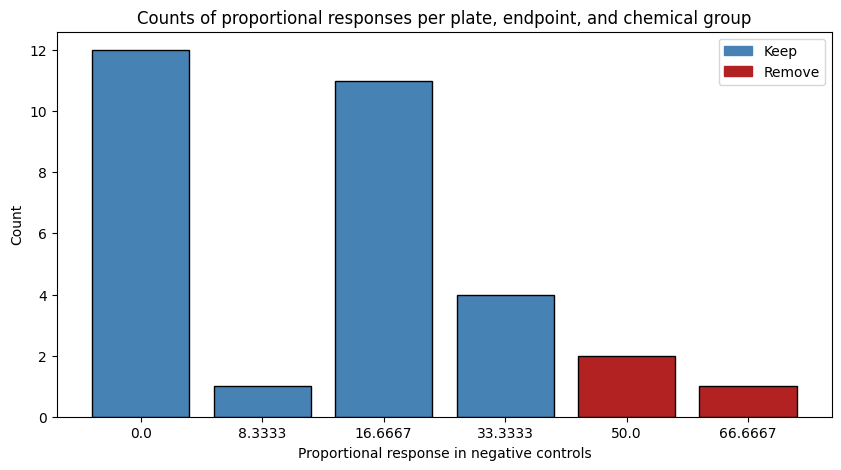

In [13]:
# Set the percentage and build the diagnostic plot, but don't actually apply the filter. 
Long.filter_negative_control(percentage = 50, apply = False, diagnostic_plot = False)

# View the plot
Long.filter_negative_control_plot

In [14]:
# View the filter summary dataframe
Long.filter_negative_control_df

,Response,Count,Filter
0,0.000000,12,Keep
1,8.333333,1,Keep
2,16.666667,11,Keep
3,33.333333,4,Keep
4,50.000000,2,Remove
5,66.666667,1,Remove


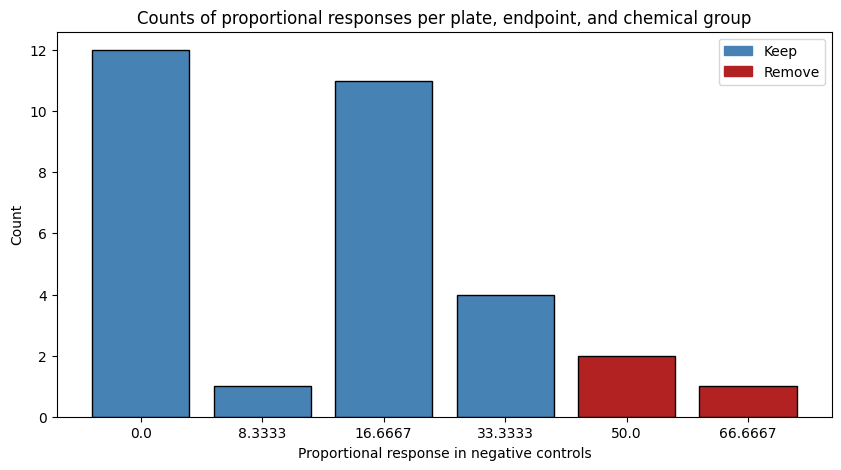

In [15]:
# Apply the negative control filter
Long.filter_negative_control(percentage = 50, apply = True)

### Minimum Concentration Filter

Another recommendation from the EPA is that any endpoints with less than 3 measurements for a specific endpoint should be tossed entirely. The default is 3. 

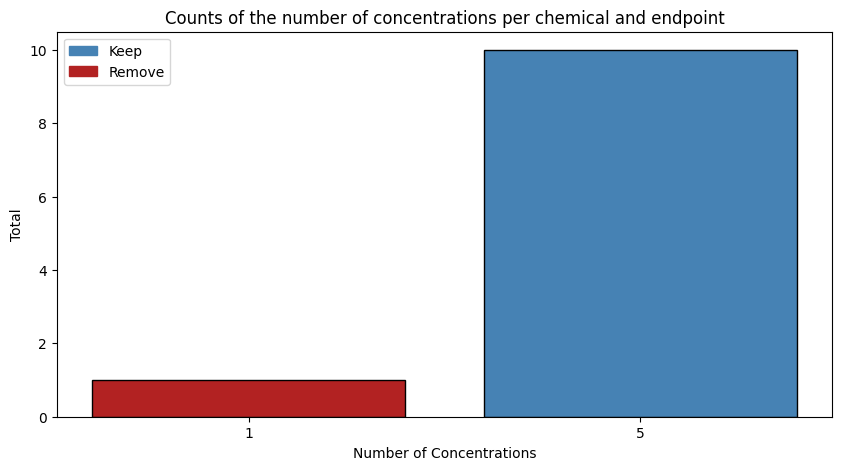

In [16]:
# Set the percentage and build the diagnostic plot, but don't actually apply the filter. 
Long.filter_min_concentration(count = 3, apply = False, diagnostic_plot = True)

In [17]:
# View the resulting data.frame
Long.filter_min_concentration_df

,NumConc,Count,Filter
0,5,10,Keep
1,1,1,Remove


In [18]:
# Apply the filter with defaults
Long.filter_min_concentration(apply = True)

### Correlation Score Filter

To fit a curve, we expect the response to increase with the dose. The EPA recommends calculated a spearman correlation, and removing endpoints that fall below a correlation score of 0.2. This also saves time on fitting models, as these endpoints are not considred in the modeling step

In [19]:
# View filter 
Long.filter_correlation_score(score = 0.2, diagnostic_plot = True, apply = False)

In [20]:
# See a data.frame of spearman correlation values 
Long.filter_correlation_score_df

,bmdrc.Endpoint.ID,Spearman,Filter
0,1 ANY,0.666737,Keep
1,1 ANY24,0.666737,Keep
2,1 DP24,0.971008,Keep
3,1 JAW,-0.142857,Remove
4,1 SM24,-0.115954,Remove
5,2 ANY,0.985611,Keep
6,2 ANY24,0.985611,Keep
7,2 DP24,0.942857,Keep
8,2 JAW,0.828571,Keep
9,2 SM24,0.753702,Keep


In [21]:
Long.filter_correlation_score(score = 0.2, apply = True)

## Module 4: Fit Models

All 7 EPA recommended models, including one additional model (Quantal Linear) are fit to the curve. The best fit is then selected in this order:

1. If the goodness-of-fit (GOF) is over the threshold (default of 0.1)

2. The lowest Akaike Information Criterion (AIC) within 2

3. If necessary, the lowest BMDL value 

The 7 recommended models are: Logistic, Log-Logistic, Probit, Log-Probit, Weibull, Gamma, and Multistage 2

In [22]:
# Set the model fits to the recommended GOF and AIC thresholds. Any models within the AIC threshold (within 2 of the lowest score, by default), are then decided by the model_selection method. 
# Currently, only "lowest BMDL" is supported. 
Long.fit_models(gof_threshold = 0.1, aic_threshold = 2, model_selection = "lowest BMDL")

In [23]:
# See summary statistics as well as benchmark dose calculations 
Long.bmds

,bmdrc.Endpoint.ID,Model,BMD10,BMDL,BMD50,AUC,Min_Dose,Max_Dose,AUC_Norm
0,1 ANY,Log Probit,0.000021,NaN,0.024599,19.025000,0.0,24.0,0.792708
1,1 ANY24,Log Probit,0.000011,NaN,0.017991,19.125000,0.0,24.0,0.796875
2,1 DP24,Weibull,1.798141,NaN,13.360780,10.475000,0.0,24.0,0.436458
3,2 ANY,Quantal Linear,2.982072,2.042621,19.618498,87.083333,0.0,100.0,0.870833
4,2 ANY24,Quantal Linear,2.982072,2.042621,19.618498,87.083333,0.0,100.0,0.870833
5,2 DP24,Log Logistic,6.321510,0.797269,72.392449,45.833333,0.0,100.0,0.458333
6,2 JAW,Log Probit,2.842871,2.390934,115.465467,66.250000,0.0,100.0,0.662500
7,2 SM24,Weibull,38.436654,12.491912,72.573447,49.583333,0.0,100.0,0.495833


In [24]:
# See summary statistics for filtered values 
Long.bmds_filtered

,bmdrc.Endpoint.ID,Model,BMD10,BMDL,BMD50,AUC,Min_Dose,Max_Dose,AUC_Norm
0,1 ANY,NaN,NaN,NaN,NaN,15.950,0.0,24.0,0.664583
1,1 ANY24,NaN,NaN,NaN,NaN,16.125,0.0,24.0,0.671875
2,1 DP24,NaN,NaN,NaN,NaN,9.175,0.0,24.0,0.382292
3,1 JAW,NaN,NaN,NaN,NaN,10.850,0.0,24.0,0.452083
4,1 NC24,NaN,NaN,NaN,NaN,0.250,0.0,1.5,0.166667
5,1 SM24,NaN,NaN,NaN,NaN,13.400,0.0,24.0,0.558333


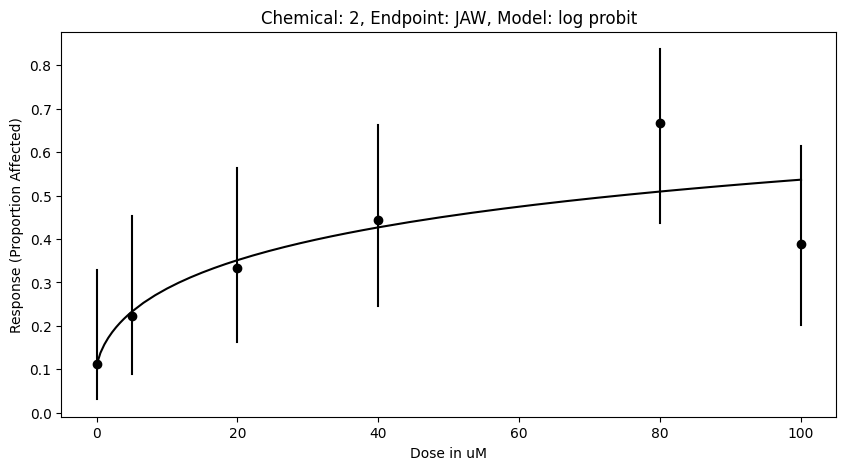

In [25]:
# Generate a plot of curve fits
Long.response_curve(chemical_name = "2", endpoint_name = "JAW", model = "log probit")
Long._2_JAW_log_probit_curve_plot

In [26]:
# See the confidence intervals 
Long._2_JAW_log_probit_confidence_intervals

,concentration,bmdrc.num.nonna,bmdrc.num.affected,bmdrc.frac.affected,Low,High
0,0.0,18,2.0,0.111111,0.031020,0.327998
1,5.0,18,4.0,0.222222,0.090009,0.452146
2,20.0,18,6.0,0.333333,0.162788,0.562505
3,40.0,18,8.0,0.444444,0.245595,0.662836
4,80.0,18,12.0,0.666667,0.437495,0.837212
5,100.0,18,7.0,0.388889,0.203052,0.613810


In [27]:
# See the curve
Long._2_JAW_log_probit_curve.head()

,Dose in uM,Response
0,0.0000,0.108849
1,0.5556,0.137739
2,1.1111,0.157036
3,1.6667,0.172374
4,2.2222,0.185353


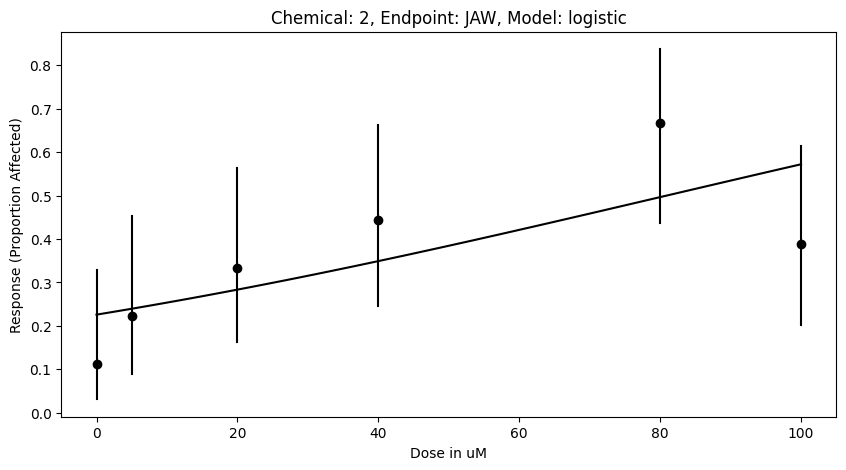

In [28]:
Long.response_curve(chemical_name = "2", endpoint_name = "JAW", model = "logistic")
Long._2_JAW_logistic_curve_plot

In [29]:
Long.plate_groups[Long.plate_groups["bmdrc.Endpoint.ID"] == "2 JAW"]

,chemical.id,concentration,plate.id,endpoint,bmdrc.num.tot,bmdrc.num.nonna,bmdrc.num.affected,bmdrc.Plate.ID,bmdrc.Endpoint.ID,bmdrc.filter,bmdrc.filter.reason,bmdrc.frac.affected
99,2,0.0,A,JAW,6,6,0.0,2 A JAW,2 JAW,Keep,,0.000000
103,2,0.0,B,JAW,6,6,0.0,2 B JAW,2 JAW,Keep,,0.000000
107,2,0.0,C,JAW,6,6,2.0,2 C JAW,2 JAW,Keep,,0.333333
112,2,5.0,A,JAW,6,6,2.0,2 A JAW,2 JAW,Keep,,0.333333
117,2,5.0,B,JAW,6,6,0.0,2 B JAW,2 JAW,Keep,,0.000000
122,2,5.0,C,JAW,6,6,2.0,2 C JAW,2 JAW,Keep,,0.333333
127,2,20.0,A,JAW,6,6,3.0,2 A JAW,2 JAW,Keep,,0.500000
132,2,20.0,B,JAW,6,6,0.0,2 B JAW,2 JAW,Keep,,0.000000
137,2,20.0,C,JAW,6,6,3.0,2 C JAW,2 JAW,Keep,,0.500000
142,2,40.0,A,JAW,6,6,4.0,2 A JAW,2 JAW,Keep,,0.666667


In [30]:
# Search for equivalent fits: p-values should be over 0.1
Long.p_value_df

,Logistic,Gamma,Weibull,Log Logistic,Probit,Log Probit,Multistage2,Quantal Linear,bmdrc.Endpoint.ID
0,0.000375,0.050247,NaN,0.019340,5.897959e-16,0.292654,NaN,0.000192,1 ANY
1,0.000328,0.047331,NaN,0.005426,1.439406e-16,0.328666,NaN,0.000160,1 ANY24
2,0.469054,0.588875,0.595280,0.697117,2.690193e-01,0.723720,5.868656e-01,0.748461,1 DP24
3,0.004244,0.065812,NaN,0.662209,NaN,NaN,1.000000e+00,0.493732,2 ANY
4,0.004244,0.065812,NaN,0.662209,NaN,NaN,1.000000e+00,0.493732,2 ANY24
5,0.124670,0.658049,0.677035,0.723900,1.129458e-05,0.729924,8.568215e-07,0.638903,2 DP24
6,0.142444,0.304786,0.314802,0.326696,1.125893e-04,0.330841,1.392850e-01,0.240683,2 JAW
7,0.225186,0.432344,0.359999,0.652906,2.188501e-01,0.652691,2.147414e-01,0.061959,2 SM24


In [31]:
# Search for an equivalent fit, AICs should be within 2 of the lowest value
Long.aic_df # Both Weibull, Log Logistic, and several others have close fits 

,Logistic,Gamma,Weibull,Log Logistic,Probit,Log Probit,Multistage2,Quantal Linear,bmdrc.Endpoint.ID
0,76.855413,65.448837,NaN,68.457570,126.526706,62.958403,NaN,74.932544,1 ANY
1,77.632543,65.977218,NaN,68.392880,129.431126,63.302153,NaN,75.749863,1 ANY24
2,86.471958,86.862896,86.841449,86.361957,87.879481,86.250852,86.866241,84.866240,1 DP24
3,103.456849,97.664892,NaN,89.307264,NaN,NaN,NaN,89.975839,2 ANY
4,103.456849,97.664892,NaN,89.307264,NaN,NaN,NaN,89.975839,2 ANY24
5,125.709901,121.733128,121.653766,121.457702,138.795561,121.437530,142.238967,120.600536,2 DP24
6,137.328336,135.908417,135.828771,135.736550,150.061355,135.705915,137.772865,135.772821,2 JAW
7,108.071025,107.131519,107.594346,105.933951,108.082124,105.934963,109.040748,112.185783,2 SM24


In [32]:
# Search for a low bmdl value 
Long.bmdls_df # The best fit is log probit, and the second best fit is quantal linear

,Logistic,Gamma,Weibull,Log Logistic,Probit,Log Probit,Multistage2,Quantal Linear,bmdrc.Endpoint.ID
0,0.843053,0.000076,0.550000,NaN,NaN,NaN,NaN,0.460179,1 ANY
1,0.836095,0.000075,0.550000,NaN,NaN,NaN,NaN,0.457716,1 ANY24
2,2.883928,NaN,0.184012,0.355818,2.702677,NaN,1.955967,1.304424,1 DP24
3,3.029032,NaN,0.550000,7.262204,0.000000,0.000000,NaN,2.042621,2 ANY
4,3.029032,NaN,0.550000,7.262204,0.000000,0.000000,NaN,2.042621,2 ANY24
5,19.985842,NaN,NaN,0.797269,13.805274,NaN,5.189281,7.982673,2 DP24
6,18.982997,NaN,NaN,NaN,13.099766,2.390934,14.577799,9.696806,2 JAW
7,13.718414,24.330544,19.243077,51.680453,13.115241,65.310932,21.803398,6.399155,2 SM24


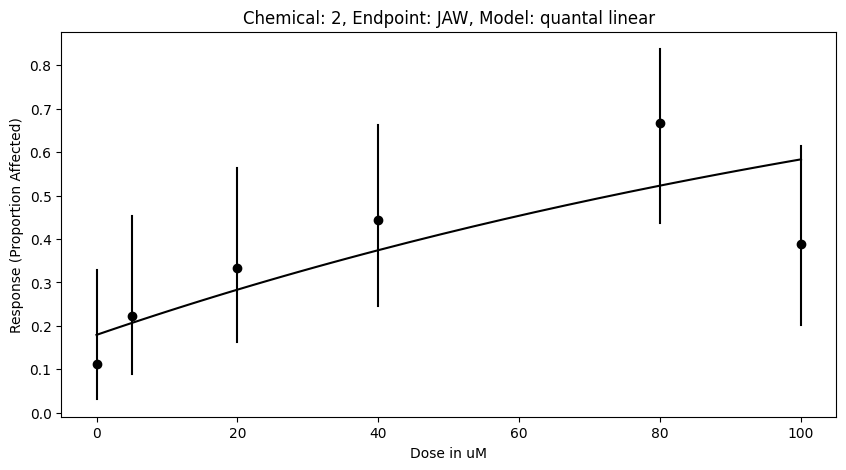

In [33]:
Long.response_curve(chemical_name = "2", endpoint_name = "JAW", model = "quantal linear")
Long._2_JAW_quantal_linear_curve_plot

## Module 5: Output

### Benchmark Dose

Build reports with the `.report()` function. See the "example_report" folder for an example. Otherwise, output a benchmark dose table with the function `.output_benchmark_dose()` and see the results with `.output_res_benchmark_dose`


In [34]:
Long.output_benchmark_dose()
Long.output_res_benchmark_dose

,Chemical_ID,End_Point,Model,BMD10,BMDL,BMD50,AUC,Min_Dose,Max_Dose,AUC_Norm,DataQC_Flag,BMD_Analysis_Flag,BMD10_Flag,BMD50_Flag,bmdrc.Endpoint.ID
0,1,ANY,Log Probit,0.000021,NaN,0.024599,19.025000,0.0,24.0,0.792708,4,2,1,1,1 ANY
1,1,ANY24,Log Probit,0.000011,NaN,0.017991,19.125000,0.0,24.0,0.796875,2,2,1,1,1 ANY24
2,1,DP24,Weibull,1.798141,NaN,13.360780,10.475000,0.0,24.0,0.436458,2,2,1,1,1 DP24
3,2,ANY,Quantal Linear,2.982072,2.042621,19.618498,87.083333,0.0,100.0,0.870833,2,2,1,1,2 ANY
4,2,ANY24,Quantal Linear,2.982072,2.042621,19.618498,87.083333,0.0,100.0,0.870833,2,2,1,1,2 ANY24
5,2,DP24,Log Logistic,6.321510,0.797269,72.392449,45.833333,0.0,100.0,0.458333,2,2,1,1,2 DP24
7,2,SM24,Weibull,38.436654,12.491912,72.573447,49.583333,0.0,100.0,0.495833,2,2,1,1,2 SM24
6,2,JAW,Log Probit,2.842871,2.390934,115.465467,66.250000,0.0,100.0,0.662500,2,1,1,0,2 JAW
3,1,JAW,NaN,NaN,NaN,NaN,10.850000,0.0,24.0,0.452083,0,0,0,0,1 JAW
4,1,NC24,NaN,NaN,NaN,NaN,0.250000,0.0,1.5,0.166667,1,0,0,0,1 NC24


### Dose

Similarly, see the dosage information with `.output_dose_table()` and see the actual table under `.output_res_dose_table`

In [35]:
Long.output_dose_table()
Long.output_res_dose_table

,Chemical_ID,End_Point,Dose,bmdrc.Endpoint.ID,num.affected,num.nonna,CI_Lo,CI_Hi,Response
0,1,ANY,0.0,1 ANY,6.0,18,0.162788,0.562505,0.333333
1,1,ANY,1.5,1 ANY,15.0,18,0.607780,0.941634,0.833333
2,1,ANY,3.0,1 ANY,12.0,17,0.468669,0.867200,0.705882
3,1,ANY,6.0,1 ANY,14.0,17,0.589705,0.938089,0.823529
4,1,ANY,12.0,1 ANY,16.0,18,0.672002,0.968980,0.888889
...,...,...,...,...,...,...,...,...,...
57,2,SM24,5.0,2 SM24,3.0,18,0.058366,0.392220,0.166667
58,2,SM24,20.0,2 SM24,4.0,18,0.090009,0.452146,0.222222
59,2,SM24,40.0,2 SM24,6.0,18,0.162788,0.562505,0.333333
60,2,SM24,80.0,2 SM24,10.0,18,0.337164,0.754405,0.555556


### Fits

And finally, see the fit information with `.output_fits_table()` and see the actual table under `.output_res_fits_table`

In [36]:
Long.output_fits_table()
Long.output_res_fits_table

,Chemical_ID,End_Point,X_vals,Y_vals,bmdrc.Endpoint.ID
0,1,ANY,0.0000,0.166515,1 ANY
1,1,ANY,0.1667,0.696162,1 ANY
2,1,ANY,0.3333,0.734622,1 ANY
3,1,ANY,0.5000,0.756134,1 ANY
4,1,ANY,0.6667,0.770887,1 ANY
...,...,...,...,...,...
41,2,SM24,91.1111,0.797296,2 SM24
42,2,SM24,93.3333,0.816717,2 SM24
43,2,SM24,95.5556,0.835075,2 SM24
44,2,SM24,97.7778,0.852323,2 SM24
